# Load Data

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
raw = pd.read_csv('interview_case_v4.csv')

In [ ]:
raw.head()

,intact_name,SIC8_DESCRIPTION,4_Square_Description,url,web_text,target_for_prediction
0,218685 Ontario Inc o/a Swagat Banquet Hall,banquet hall facilities,NaN,WWW.SWAGATBANQUETHALL.COM,"WE'RE MAJESTIC, REGAL, STYLISH& EXPERTS IN ALL...",Restaurant
1,Restaurant Pushap Sucrerie,eating places,snack and nonalcoholic beverage bars,NaN,NaN,Restaurant
2,Transport Galf Inc.,NaN,NaN,NaN,NaN,Trucking & Hauling Service
3,On The Go Courier,NaN,specialized freight (except used goods) trucki...,NaN,NaN,Trucking & Hauling Service
4,1484726 Alberta Ltd,"local trucking, without storage",NaN,NaN,NaN,Trucking & Hauling Service


In [ ]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [ ]:
missing_values_table(raw)

Your selected dataframe has 6 columns.
There are 4 columns that have missing values.


,Missing Values,% of Total Values
web_text,1118,71.5
url,999,63.9
4_Square_Description,664,42.5
SIC8_DESCRIPTION,528,33.8


There are too many missing values in web_text.

In [ ]:
raw['SIC8_DESCRIPTION'].nunique()

235

In [ ]:
raw['4_Square_Description'].nunique()

103

In [ ]:
raw['web_text'].nunique()

424

# EDA

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:xlabel='target_for_prediction', ylabel='Count'>

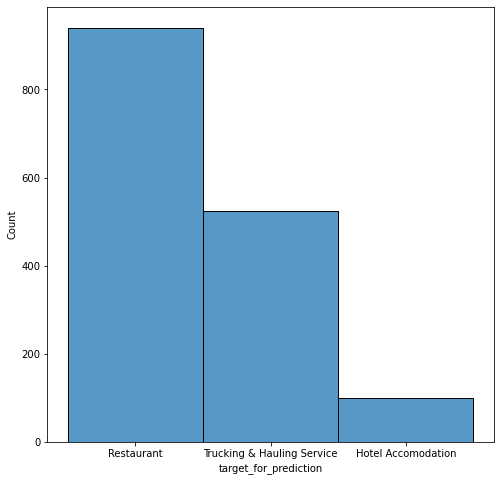

In [ ]:
plt.figure(figsize = (8,8))
sns.histplot(data=raw, x="target_for_prediction")

Very imbalanced, we need to take care of this in the later stage.

In [ ]:
raw['4_Square_Description'].value_counts()

snack and nonalcoholic beverage bars                               466
specialized freight (except used goods) trucking, local             94
casino hotels                                                       54
specialized freight (except used goods) trucking, long distance     51
site preparation contractors                                        23
                                                                  ... 
used car dealers                                                     1
dairy product (except dried or canned) merchant wholesalers          1
lumber, plywood, millwork, and wood panel merchant wholesalers       1
soil preparation, planting, and cultivating                          1
support activities for rail transportation                           1
Name: 4_Square_Description, Length: 103, dtype: int64

In [ ]:
raw['SIC8_DESCRIPTION'].value_counts()

eating places                             267
local trucking, without storage            63
pizza restaurants                          60
hotels                                     41
trucking, except local                     41
                                         ... 
air passenger carrier, scheduled            1
mine exploration, nonmetallic minerals      1
sign painting and lettering shop            1
general farms, primarily crop               1
planing mill products and lumber            1
Name: SIC8_DESCRIPTION, Length: 235, dtype: int64

# Model 1- BERT + MLP

Consedering the huge amount of missing values in web_text, I would discard it first, only use the first three columns for modeling. <br/>
<br/>
How to combine those three columns? First intuive way coming to my mind is to concat them all to one single text. I think this is reasonable because three columns are not completly independent, they are sort of correlated, can be considered as 'sequence' when combined together. And there is no strong sequential and contextual information for each text source, so combined with other sources would not affect that much.
<br/>
<br/>
Due to the limited computation resources, I will freeze the BERT parameter during training.

## 1) Train and Test Split

In [ ]:
df = raw.copy()
df['intact_name'] = df['intact_name'].str.rstrip('.') # remove the periord from the end of string
df = df.fillna('')
df['text'] = df['intact_name'].astype(str)+'. ' +df['SIC8_DESCRIPTION'].astype(str)+'. ' +df['4_Square_Description'].astype(str)
df1 = df[['text','target_for_prediction']]
df1 = df1.rename(columns={'target_for_prediction':'label'})

In [ ]:
df1

,text,label
0,218685 Ontario Inc o/a Swagat Banquet Hall. ba...,Restaurant
1,Restaurant Pushap Sucrerie. eating places. sna...,Restaurant
2,Transport Galf Inc. .,Trucking & Hauling Service
3,On The Go Courier. . specialized freight (exce...,Trucking & Hauling Service
4,"1484726 Alberta Ltd. local trucking, without s...",Trucking & Hauling Service
...,...,...
1558,Asdin Hospitality Ltd. o/a Best Western Plus F...,Hotel Accomodation
1559,Casa Moda Fine Furnishing Inc. .,Trucking & Hauling Service
1560,Jia De Trinh o/a Oakridge Dragon Restaurant Lt...,Restaurant
1561,2000650 Ontario Inc. o/a Golden Bell Thai Rest...,Restaurant


In [ ]:
from sklearn.model_selection import train_test_split

training_data, test_data = train_test_split(df1, test_size=0.1, random_state=25, stratify = df1.label)
train_data, valid_data = train_test_split(training_data, test_size=0.1, random_state=25, stratify = training_data.label)

In [ ]:
print(f'training data size: {train_data.shape[0]}')
print(f'validation data size: {valid_data.shape[0]}')
print(f'testing data size: {test_data.shape[0]}')

training data size: 1265
validation data size: 141
testing data size: 157


In [ ]:
# save three datasets, for later torchtext use
train_data.to_csv('./data1/train.csv',index=False)
valid_data.to_csv('./data1/valid.csv',index=False)
test_data.to_csv('./data1/test.csv',index=False)

## 2) Prepare Data & Iterator

In [ ]:
import torch

import random
import numpy as np

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
init_token = tokenizer.cls_token
eos_token = tokenizer.sep_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token

init_token_idx = tokenizer.convert_tokens_to_ids(init_token)
eos_token_idx = tokenizer.convert_tokens_to_ids(eos_token)
pad_token_idx = tokenizer.convert_tokens_to_ids(pad_token)
unk_token_idx = tokenizer.convert_tokens_to_ids(unk_token)

In [ ]:
max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']
print(max_input_length)

512


In [ ]:
def tokenize_and_cut(sentence):
    tokens = tokenizer.tokenize(sentence) 
    tokens = tokens[:max_input_length-2] # we have to add two tokens: at the beginning and end of the text
    return tokens

In [ ]:
from torchtext.legacy import data

TEXT = data.Field(batch_first = True,
                  use_vocab = False,
                  tokenize = tokenize_and_cut,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = init_token_idx,
                  eos_token = eos_token_idx,
                  pad_token = pad_token_idx,
                  unk_token = unk_token_idx)

LABEL = data.LabelField(dtype = torch.float)

In [ ]:
fields = [('text', TEXT), ('label', LABEL)]

In [ ]:
train_data, valid_data, test_data = data.TabularDataset.splits(
                                        path = 'data1',
                                        train = 'train.csv',
                                        validation = 'valid.csv',
                                        test = 'test.csv',
                                        format = 'csv',
                                        fields = fields,
                                        skip_header = True
)

In [ ]:
print(vars(train_data[0]))

{'text': [22431, 19961, 2620, 2620, 4561, 4297, 1012, 1004, 23968, 1005, 1055, 10733, 1012, 10733, 7884, 1012], 'label': 'Restaurant'}


In [ ]:
LABEL.build_vocab(train_data)
print(LABEL.vocab.stoi)

defaultdict(None, {'Restaurant': 0, 'Trucking & Hauling Service': 1, 'Hotel Accomodation': 2})


In [ ]:
BATCH_SIZE = 16 # consider the samll dataset and limited computational resources, I set a small batch size

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    sort = False,
    batch_size = BATCH_SIZE, 
    device = device)

## 3) Build the Model

In [ ]:
from transformers import BertTokenizer, BertModel

In [ ]:
bert = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
import torch.nn as nn

class BERTMLPSentiment(nn.Module):
    def __init__(self,
                 bert,
                 output_dim
                ):
        
        super().__init__()
        
        self.bert = bert
        
        embedding_dim = bert.config.to_dict()['hidden_size']
        
        self.out = nn.Linear(embedding_dim, output_dim) # input dimension = hidden_size
        
        
    def forward(self, text):
        
        #text = [batch size, sent len]
                
        with torch.no_grad():
            cls_embedded = self.bert(text)[1]  # freeze the bert para, get the representation of [cls] token
        
                
        #cls_embedded = [batch size, 1, emb dim]
        
        output = self.out(cls_embedded)
        
        #output = [batch size, out dim]
        
        return output

In [ ]:
OUTPUT_DIM = 3

model_1 = BERTMLPSentiment(bert,
                         OUTPUT_DIM)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model_1):,} trainable parameters')

The model has 109,484,547 trainable parameters


In [ ]:
# too many parameters to train, I will freeze the bert para, due to the limited sources
for name, param in model_1.named_parameters():                
    if name.startswith('bert'):
        param.requires_grad = False

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model_1):,} trainable parameters')

The model has 2,307 trainable parameters


In [ ]:
for name, param in model_1.named_parameters():                
    if param.requires_grad:
        print(name)

out.weight
out.bias


## 4) Train the Model

In [ ]:
import sklearn.utils.class_weight as class_weight

In [ ]:
train_df = pd.read_csv('./data1/train.csv')
train_Y = train_df.label
train_Y = train_Y.apply(lambda x: 0 if x=='Restaurant' else 1 if x=='Trucking & Hauling Service' else 2) # according to the LABEL.vocab 

In [ ]:
class_weights=class_weight.compute_class_weight('balanced',np.unique(train_Y),train_Y.to_numpy())
class_weights=torch.tensor(class_weights,dtype=torch.float)
class_weights

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2], y=[0 0 1 ... 2 1 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


tensor([0.5541, 0.9945, 5.2708])

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model_1.parameters())

criterion = nn.CrossEntropyLoss(weight=class_weights) # to deal with the imbalanced dataset

model_1 = model_1.to(device)
criterion = criterion.to(device)

In [ ]:
def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch
    """
    top_pred = preds.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text)
        
        loss = criterion(predictions, batch.label.long())
        
        acc = categorical_accuracy(predictions, batch.label.long())
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text)
            
            loss = criterion(predictions, batch.label.long())
            
            acc = categorical_accuracy(predictions, batch.label.long())

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model_1, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model_1, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_1.state_dict(), 'model1.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 53s
	Train Loss: 1.108 | Train Acc: 45.08%
	 Val. Loss: 1.007 |  Val. Acc: 63.57%
Epoch: 02 | Epoch Time: 0m 52s
	Train Loss: 1.017 | Train Acc: 60.62%
	 Val. Loss: 1.001 |  Val. Acc: 74.52%
Epoch: 03 | Epoch Time: 0m 52s
	Train Loss: 1.018 | Train Acc: 55.47%
	 Val. Loss: 0.911 |  Val. Acc: 52.51%
Epoch: 04 | Epoch Time: 0m 59s
	Train Loss: 0.910 | Train Acc: 67.50%
	 Val. Loss: 0.859 |  Val. Acc: 78.69%
Epoch: 05 | Epoch Time: 0m 57s
	Train Loss: 0.866 | Train Acc: 70.08%
	 Val. Loss: 0.872 |  Val. Acc: 76.98%


# Model 2- BERT + RNN

In the Model 1, BERT with MLP, I use [CLS] Token from BERT as input for MLP. When using RNN after BERT, I will use the embedding for whole sentence as inputs for RNN.
<br/>
Likewise, I will freeze the BERT parameters, only train the parameters for RNN.
<br/>
For RNN architecture, I choose GRU.
<br/>
Preparing data and iterator is basically the same, I will skip these two here.

## 3) Build the Model

In [ ]:
import torch.nn as nn

class BERTGRUSentiment(nn.Module):
    def __init__(self,
                 bert,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):
        
        super().__init__()
        
        self.bert = bert
        
        embedding_dim = bert.config.to_dict()['hidden_size']
        
        self.rnn = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)
        
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [batch size, sent len]
                
        with torch.no_grad():
            embedded = self.bert(text)[0]
                
        #embedded = [batch size, sent len, emb dim]
        
        _, hidden = self.rnn(embedded)
        
        #hidden = [n layers * n directions, batch size, emb dim]
        
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
                
        #hidden = [batch size, hid dim]
        
        output = self.out(hidden)
        
        #output = [batch size, out dim]
        
        return output

In [ ]:
HIDDEN_DIM = 128
OUTPUT_DIM = 3
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.1

model2 = BERTGRUSentiment(bert,
                         HIDDEN_DIM,
                         OUTPUT_DIM,
                         N_LAYERS,
                         BIDIRECTIONAL,
                         DROPOUT)

In [ ]:
# too many parameters to train, I will freeze the bert para, due to the limited sources
for name, param in model2.named_parameters():                
    if name.startswith('bert'):
        param.requires_grad = False

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model2):,} trainable parameters')

The model has 986,883 trainable parameters


In [ ]:
for name, param in model2.named_parameters():                
    if param.requires_grad:
        print(name)

rnn.weight_ih_l0
rnn.weight_hh_l0
rnn.bias_ih_l0
rnn.bias_hh_l0
rnn.weight_ih_l0_reverse
rnn.weight_hh_l0_reverse
rnn.bias_ih_l0_reverse
rnn.bias_hh_l0_reverse
rnn.weight_ih_l1
rnn.weight_hh_l1
rnn.bias_ih_l1
rnn.bias_hh_l1
rnn.weight_ih_l1_reverse
rnn.weight_hh_l1_reverse
rnn.bias_ih_l1_reverse
rnn.bias_hh_l1_reverse
out.weight
out.bias


## 4) Train the Model

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model2.parameters())

criterion = nn.CrossEntropyLoss(weight=class_weights) # to deal with the imbalanced dataset

model2 = model2.to(device)
criterion = criterion.to(device)

In [ ]:
def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch
    """
    top_pred = preds.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label.long())
        
        acc = categorical_accuracy(predictions, batch.label.long())
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label.long())
            
            acc = categorical_accuracy(predictions, batch.label.long())

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model2, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model2, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model2.state_dict(), 'model2.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 56s
	Train Loss: 0.686 | Train Acc: 73.59%
	 Val. Loss: 0.539 |  Val. Acc: 86.49%
Epoch: 02 | Epoch Time: 1m 1s
	Train Loss: 0.407 | Train Acc: 86.80%
	 Val. Loss: 0.539 |  Val. Acc: 84.24%
Epoch: 03 | Epoch Time: 1m 7s
	Train Loss: 0.317 | Train Acc: 89.14%
	 Val. Loss: 0.385 |  Val. Acc: 85.79%
Epoch: 04 | Epoch Time: 1m 6s
	Train Loss: 0.245 | Train Acc: 91.41%
	 Val. Loss: 0.484 |  Val. Acc: 85.63%
Epoch: 05 | Epoch Time: 0m 57s
	Train Loss: 0.216 | Train Acc: 92.11%
	 Val. Loss: 0.498 |  Val. Acc: 89.96%


# Evaluate on Test

In [ ]:
model2.load_state_dict(torch.load('model2.pt'))

test_loss, test_acc = evaluate(model2, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.330 | Test Acc: 84.09%
